In [1]:
import gym
import numpy as np
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
env = gym.make('ma_gym:PredatorPrey5x5-v0')

In [3]:
len(env.observation_space)

2

In [4]:
env.observation_space[0]

Box([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.], (28,), float32)

In [5]:
env.prey_pos

{0: None}

In [6]:
env.agent_pos

{0: None, 1: None}

In [7]:
type(env.action_space.sample())

list

# --------------------------------------------------------------------------------------------------------------

## Environment Dynamics:

In [3]:
def state_to_encoding(state):
    encoding = 0
    for i in range(len(state)):
        encoding += (5**(5-i))*int(state[i])
    return encoding

In [4]:
def encoding_to_state(encoding):
    state = ""
    for i in range(5, 0, -1):
        remainder = encoding % 5
        encoding = encoding//5
        state = str(remainder) + state
    remainder = encoding % 5
    state = str(remainder) + state
    return state

In [5]:
def action_to_encoding(action):
    encoding = 0
    for i in range(len(action)):
        encoding += (5**(1-i))*int(action[i])
    return encoding

In [6]:
def encoding_to_action(encoding):
    action = ""
    remainder = encoding % 5
    encoding = encoding//5
    action = str(int(remainder)) + action
    remainder = encoding % 5
    action = str(int(remainder)) + action
    return action

In [7]:
def get_next_state(state, action):
    
    #Encoding in general means the number, state is the string
    state = encoding_to_state(state)
    action = encoding_to_action(action)
    
    good_noop = 0
    noop_1 = 0
    noop_2 = 0
    
    #STATE:
    #First 2, Second 2, Third 2, depict the positions of the 1st pred, 2nd pred, and prey respectively.
    
    #PREDATOR 1:
    
    if action[0] == "0":
        if state[0] != "4":
            state = state[:0] + str(int(state[0]) + 1) + state[1:]
    if action[0] == "1":
        if state[1] != "0":
            state = state[:1] + str(int(state[1]) - 1) + state[2:]
    if action[0] == "2":
        if state[0] != "0":
            state = state[:0] + str(int(state[0]) - 1) + state[1:]
    if action[0] == "3":
        if state[1] != "4":
            state = state[:1] + str(int(state[1]) + 1) + state[2:]
    if action[0] == "4":
        if (abs(int(state[4]) - int(state[0])) == 1 and abs(int(state[5]) - int(state[1])) == 0) or (abs(int(state[4]) - int(state[0])) == 0 and abs(int(state[5]) - int(state[1])) == 1):
            noop_1 = 1
        
    #PREDATOR 2:
    
    if action[1] == "0":
        if state[2] != "4":
            state = state[:2] + str(int(state[2]) + 1) + state[3:]
    if action[1] == "1":
        if state[3] != "0":
            state = state[:3] + str(int(state[3]) - 1) + state[4:]
    if action[1] == "2":
        if state[2] != "0":
            state = state[:2] + str(int(state[2]) - 1) + state[3:]
    if action[1] == "3":
        if state[3] != "4":
            state = state[:3] + str(int(state[3]) + 1) + state[4:]
    if action[1] == "4":
        if (abs(int(state[4]) - int(state[2])) == 1 and abs(int(state[5]) - int(state[3])) == 0) or (abs(int(state[4]) - int(state[2])) == 0 and abs(int(state[5]) - int(state[3])) == 1):
            noop_2 = 1
            
    reward_array = np.zeros((4,))
    state_array = [state, state, state, state]
    prev_state_array = state_array[:]
    
    #All Possible Next States:
    
    if state_array[0][4] != "4":
        state_array[0] = state_array[0][:4] + str(int(state_array[0][4]) + 1) + state_array[0][5:]
    if state_array[1][5] != "0":
        state_array[1] = state_array[1][:5] + str(int(state_array[1][5]) - 1)
    if state_array[2][4] != "0":
        state_array[2] = state_array[2][:4] + str(int(state_array[2][4]) - 1) + state_array[2][5:]
    if state_array[3][5] != "4":
        state_array[3] = state_array[3][:5] + str(int(state_array[3][5]) + 1)
    
            
    #TERMINAL CASES:
    
    for i in range(len(state_array)):

#         if action[0] == "4":
#             if abs(int(state_array[i][4]) - int(state_array[i][0])) == 1 or abs(int(state_array[i][5]) - int(state_array[i][1])) == 1:
#                 noop_1 = 1

#         if action[1] == "4":
#             if abs(int(state_array[i][4]) - int(state_array[i][2])) == 1 or abs(int(state_array[i][5]) - int(state_array[i][3])) == 1:
#                 noop_2 = 1
        
        if (noop_1 + noop_2) == 2:          #Correct Noop
            state_array[i] = state_to_encoding(state_array[i])
            reward_array[i] = 1
        elif (noop_1 + noop_2) == 1:        #Wrong Noop       
            state_array[i] = state_to_encoding(state_array[i])
            reward_array[i] = -0.5
        elif (action[0] == "4" and noop_1 == 0) or (action[1] == "4" and noop_2 == 0):  #Terrible Noop
            state_array[i] = state_to_encoding(state_array[i])
            reward_array[i] = -1
        #Collision:
        elif (state_array[i][:2] == state_array[i][2:4]) or (state_array[i][2:4] == state_array[i][4:]) or (state_array[i][:2] == state_array[i][4:]):
            state_array[i] = state_to_encoding(prev_state_array[:][i])
            reward_array[i] = -0.5
        #Movement Collision:
        elif (state_array[i][:2] == prev_state_array[i][2:4] and prev_state_array[i][:2] == state_array[i][2:4]) or (state_array[i][4:] == prev_state_array[i][2:4] and prev_state_array[i][4:] == state_array[i][2:4]) or (state_array[i][:2] == prev_state_array[i][4:] and prev_state_array[i][:2] == state_array[i][4:]):
            state_array[i] = state_to_encoding(prev_state_array[:][i])
            reward_array[i] = -0.5
        else:
            state_array[i] = state_to_encoding(state_array[i])
            reward_array[i] = -0.01
        
    
    return reward_array, state_array
    

In [8]:
encoded_action = action_to_encoding("31")
encoded_state = state_to_encoding("111224")
reward, next_state = get_next_state(encoded_state, encoded_action)
print(next_state, reward)
encoding_to_state(next_state[1])

[4544, 4538, 4534, 4539] [-0.01 -0.01 -0.01 -0.01]


'121123'

In [9]:
state = "001144"

In [10]:
#0-->Down
#1-->Left
#2-->Up
#3-->Right
action_dict = {0:"Down", 1:"Left", 2:"Up", 3:"Right", 4:"Noop"}

encoded_state = state_to_encoding(state)
encoded_action = action_to_encoding("20")
state = get_next_state(encoded_state, encoded_action)

## Agent:

In [11]:
class Agent():
    
    def __init__(self, env):
        self.env = env
        self.n = len(self.env.observation_space) + 1              # 1 prey
        self.num_states = 5**(2*self.n)    # 5 rows/columns squared for area and multiplied by number of agents including prey
        self.num_actions = 5*5
        self.values = np.random.rand(self.num_states)            
        self.policy = np.zeros(self.num_states, )
        
        
    def value_iterate(self, theta = 0.01, gamma = 0.5, save = False):
        
        while True:
            delV = 0
            for state in range(self.num_states):
                prev_value = self.values[state]
                action_values = []
                for action in range(self.num_actions):
                    reward_array, next_state_array = get_next_state(state, action)
                    next_state_vals = 0
                    for i in range(len(next_state_array)):
                        if next_state_array[i] == -1:
                            next_state_vals += (0.25*reward_array[i])
                        else:
                            next_state_vals += (0.25*(reward_array[i] + gamma*self.values[next_state_array[i]]))
                    action_values.append(next_state_vals)
                self.values[state] = max(action_values)
                delV = max(delV, abs(prev_value - self.values[state]))
            print(delV)
            if delV < theta:
                #print(action_values)
                break
            
                
        for state in range(self.num_states):
            action_values = []
            for action in range(self.num_actions):
                reward_array, next_state_array = get_next_state(state, action)
                next_state_vals = 0
                for i in range(len(next_state_array)):
                    if next_state_array[i] == -1:
                        next_state_vals += (0.25*reward_array[i])
                    else:
                        next_state_vals += (0.25*(reward_array[i] + gamma*self.values[next_state_array[i]]))
                action_values.append(next_state_vals)
            action_values = np.array(action_values)
            self.policy[state] = np.argmax(action_values)
            #print(action_values, self.policy[state])
        
        if save:
            np.save("DP_policy.npy", self.policy)

                
    def analyse_episode(self):
        
        dones = [False for _ in range(self.env.n_agents)]
        action = [0, 0]
        reward = [0, 0]
        my_reward = [0, 0]
        info = None
        
        _ = self.env.reset()
        count = 0
        
        self.env.render()
        _ = input("Press Enter to start simulation")
        
        while not all(dones):
            
            #clear_output(wait = True)
            self.env.render()
            
            a1_pos = str(self.env.agent_pos[0][0]) + str(self.env.agent_pos[0][1])
            a2_pos = str(self.env.agent_pos[1][0]) + str(self.env.agent_pos[1][1])
            prey_pos = str(self.env.prey_pos[0][0]) + str(self.env.prey_pos[0][1])
            
            state_string = a1_pos + a2_pos + prey_pos
            state_encoding = state_to_encoding(state_string)
            action_encoding = self.policy[state_encoding]
            action_string = encoding_to_action(action_encoding)
            action[0], action[1] = int(action_string[0]), int(action_string[1])
            print(" ")
            print("-----------------------------------------------------------------------------------")
            print(action_dict[action[0]], action_dict[action[1]])
            print("Current state in their representation = ", state_string)
            my_reward, my_next_state = get_next_state(state_encoding, action_encoding)
            _ = input("Does the action make sense? Press Enter to execute")
            
            _, reward, dones, info = self.env.step(action)
            
            print("REWARD = ", my_reward)
            print("Is agent done?: ", dones)
            self.env.render()
            

In [13]:
agent = Agent(env)

In [14]:
agent.policy = np.load("DP_policy.npy")
print(agent.policy)

[15. 24. 18. ...  6. 24.  7.]


In [19]:
agent.value_iterate(theta = 0.01, gamma = 0.9, save = False)

1.7815917622652238
0.8808317273182067
0.748936410974173
0.5195209758163374
0.4146785777410069
0.32743105044456455
0.2679261496155172
0.231403068569644
0.19869120725867462
0.16963945073456532
0.14278840215912547
0.1172898988727602
0.09615829968708578
0.07844519276945894
0.06368568860644919
0.054258567183148365
0.046693814871447525
0.040120067700834205
0.034449886878050506
0.02953532600179276
0.025294542535058362
0.0216335434691155
0.018480459808377425
0.015767574625231262
0.013437096057771214
0.011437785183667337
0.009725035305041096


In [20]:
np.save("DP_policy_gamma001.npy", agent.policy)

In [19]:
agent.env.close()

In [18]:
agent.analyse_episode()

Press Enter to start simulation
 
-----------------------------------------------------------------------------------
Right Left
Current state in their representation =  002312
Does the action make sense? Press Enter to execute
REWARD =  [-0.5  -0.01 -0.01 -0.01]
Is agent done?:  [False, False]
 
-----------------------------------------------------------------------------------
Up Up
Current state in their representation =  012212
Does the action make sense? Press Enter to execute
REWARD =  [-0.01 -0.01 -0.01 -0.01]
Is agent done?:  [False, False]
 
-----------------------------------------------------------------------------------
Up Up
Current state in their representation =  012212
Does the action make sense? Press Enter to execute
REWARD =  [-0.01 -0.01 -0.01 -0.01]
Is agent done?:  [False, False]
 
-----------------------------------------------------------------------------------
Right Right
Current state in their representation =  012213
Does the action make sense? Press Enter 

In [32]:
def value_heatmap(values, half_state = "2233"):
    
    heatmap = np.zeros((5,5))
    
    for i in range(5):
        for j in range(5):

            state_encoding = state_to_encoding(str(i) + str(j) + half_state)
            heatmap[i, j] = values[state_encoding]
            
    return heatmap

[[0.11044947 0.86519987 0.69089671 0.2092728  0.43139052]
 [0.85289381 0.9769313  0.54766113 0.34265245 0.09834505]
 [0.63653723 0.09979531 0.42688338 0.22038347 0.95113388]
 [0.48131596 0.42086434 0.59614397 0.73815497 0.71963159]
 [0.9100647  0.61134894 0.90825994 0.98258555 0.79674944]]


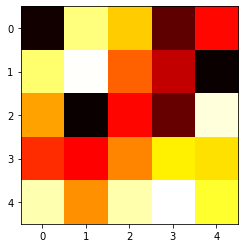

In [33]:
heatmap = value_heatmap(agent.values, half_state = "2233")
print(heatmap)
plt.imshow(heatmap, cmap="hot", interpolation="nearest")